# Harmonization of MODIS and AVHRR

Following [Rifai et al. (2022)](https://bg.copernicus.org/articles/19/491/2022/)

    <var>-MODIS = s(<var>-AVHRR)+s(month)+s(SZA)+s(TOD)+s(x,y)

This process was run using an R script and the `mgcv` package. This notebook post-processes the output of the GAM harmonization:
- Create plots of before and after harmonization
- Merging the calibrated AVHRR with MODIS to create a continous time-series 1982-2022
- Gapfilling
    
        
    


In [1]:
import numpy as np
import xarray as xr
import seaborn as sb
import pandas as pd
import geopandas as gpd
from scipy import stats
import xskillscore as xs
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import FormatStrFormatter

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

## Open datasets

In [2]:
var='ndvi'
crs='epsg:3577'

base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

trees_lgbm = xr.open_dataset(base+'NDVI_harmonization/NDVI_trees_LGBM_harmonize_test_5km_monthly_1982_2013.nc')['NDVI']

nontrees_lgbm = xr.open_dataset(base+'NDVI_harmonization/NDVI_nontrees_LGBM_harmonize_test_5km_monthly_1982_2013.nc')['NDVI']

avhrr = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/AVHRR_5km_monthly_1982_2013.nc')['NDVI_median']
avhrr = assign_crs(avhrr, crs ='epsg:3577')

modis = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/MODIS_NDVI_5km_monthly_2001_2022.nc')['NDVI_median']
modis = assign_crs(modis, crs ='epsg:3577')

### Combine trees and nontrees model predictions

In [3]:
merge = xr.where(np.isnan(trees_lgbm), nontrees_lgbm, trees_lgbm)

#ensure we only have data where there is AVHRR data (this is unnecessary but being sure)
avhrr_mask = ~np.isnan(avhrr.sel(time=slice('2001', '2013')))
merge = merge.where(avhrr_mask)

#clip MODIS to same areas
modis = modis.sel(time=slice('2001', '2013')).where(avhrr_mask)

## Comparisons

### Scatter plots of before and after harmonization

Per bioclimatic region

In [4]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')
n_samples=30000

In [5]:
# Dictionary to save results 
results = []
for index, row in gdf.iterrows():

    n=int(n_samples/6)        

    print(row['region_name'], n)
    
    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], merge, crs='epsg:3577')
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    modis_flat = modis.where(mask).values.flatten()
    avhrr_flat = avhrr.where(mask).sel(time=slice('2001', '2013')).values.flatten()
    avhrr_adjust = merge.where(mask).values.flatten()

    df = pd.DataFrame({'MODIS':modis_flat, 'AVHRR-original':avhrr_flat, 'AVHRR-adjusted':avhrr_adjust})
    df = df.dropna().sample(n=n, random_state=0).reset_index(drop=True)
    df['Region'] = row['region_name']
    results.append(df)

df = pd.concat(results).reset_index(drop=True)

Tropics 5000
Savanna 5000
Warm Temperate 5000
Cool Temperate 5000
Mediterranean 5000
Desert 5000


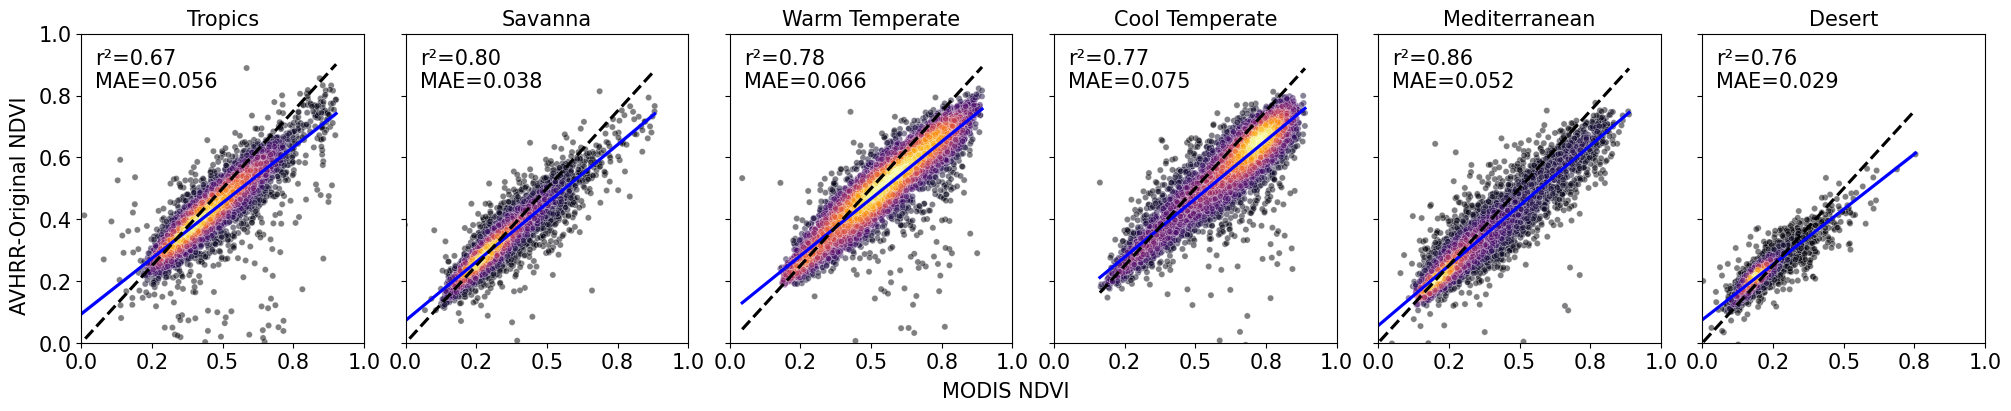

In [7]:
fig,ax = plt.subplots(1,6, figsize=(20,4), sharey=True, layout='constrained')
font=15

for ax, region in zip(ax.ravel(), list(df['Region'].unique())):
    df_region = df[df['Region']==region]
    obs,pred = df_region['MODIS'].values, df_region['AVHRR-original'].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    r2 = r_value**2
    ac = mean_absolute_error(obs, pred)
    
    xy = np.vstack([obs,pred])
    z = gaussian_kde(xy)(xy)
    
    sb.scatterplot(data=df_region, x='MODIS',y='AVHRR-original', c=z, s=20, lw=1, alpha=0.5, ax=ax, cmap='inferno')
    sb.regplot(data=df_region, x='MODIS',y='AVHRR-original', scatter=False, color='blue', ax=ax)
    sb.regplot(data=df_region, x='MODIS',y='MODIS', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
    
    ax.set_title(region, fontsize=font)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(0.0,1.0)
    ax.set_xlim(0.0,1.0)
    ax.text(.05, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=font)
    ax.text(.05, .825, 'MAE={:.2g}'.format(np.mean(ac)),
            transform=ax.transAxes, fontsize=font)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    ax.tick_params(axis='x', labelsize=font)
    ax.tick_params(axis='y', labelsize=font)

fig.supylabel('AVHRR-Original '+var.upper(), fontsize=font)
fig.supxlabel('MODIS '+var.upper(), fontsize=font);
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/MODIS_AVHRR_"+var+"_onetoone_before_harmonization.png", bbox_inches='tight', dpi=300);

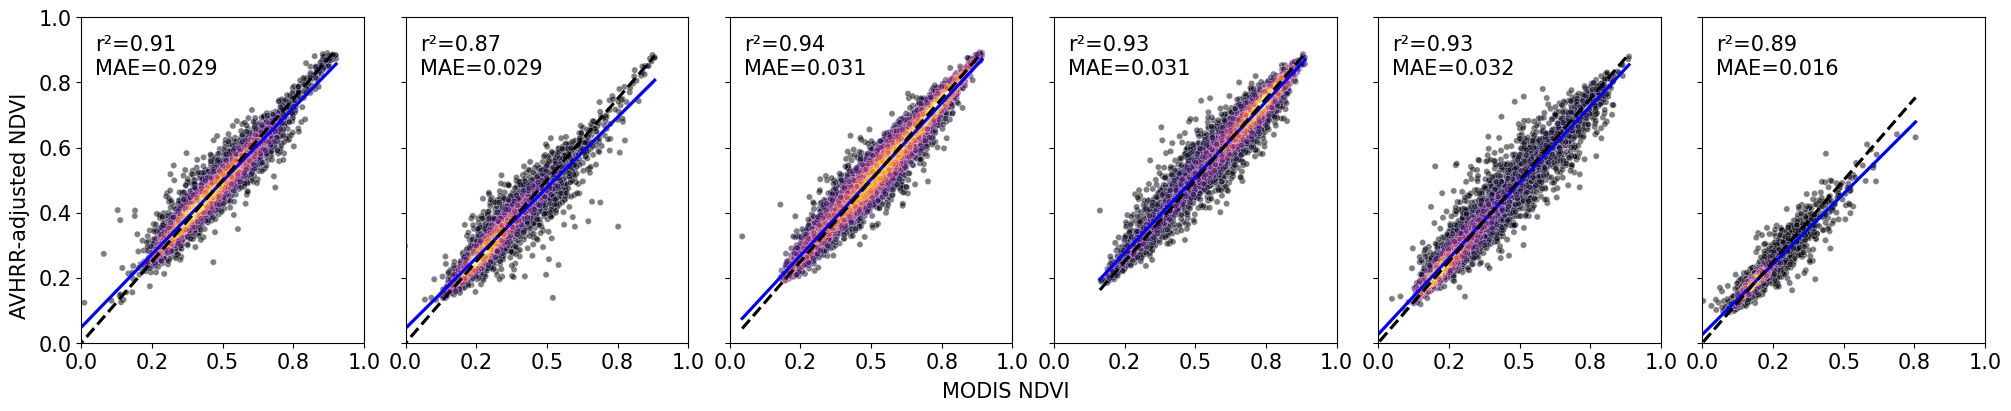

In [8]:
fig,ax = plt.subplots(1,6, figsize=(20,4), sharey=True, layout='constrained')
font=15

for ax, region in zip(ax.ravel(), list(df['Region'].unique())):
    df_region = df[df['Region']==region]
    obs,pred = df_region['MODIS'].values, df_region['AVHRR-adjusted'].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    r2 = r_value**2
    ac = mean_absolute_error(obs, pred)
    
    xy = np.vstack([obs,pred])
    z = gaussian_kde(xy)(xy)
    
    sb.scatterplot(data=df_region, x='MODIS',y='AVHRR-adjusted', c=z, s=20, lw=1, alpha=0.5, ax=ax, cmap='inferno')
    sb.regplot(data=df_region, x='MODIS',y='AVHRR-adjusted', scatter=False, color='blue', ax=ax)
    sb.regplot(data=df_region, x='MODIS',y='MODIS', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
    
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_ylim(0.0,1.0)
    ax.set_xlim(0.0,1.0)
    ax.text(.05, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=font)
    ax.text(.05, .825, 'MAE={:.2g}'.format(np.mean(ac)),
            transform=ax.transAxes, fontsize=font)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    ax.tick_params(axis='x', labelsize=font)
    ax.tick_params(axis='y', labelsize=font)

fig.supylabel('AVHRR-adjusted '+var.upper(), fontsize=font)
fig.supxlabel('MODIS '+var.upper(), fontsize=font);
fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/MODIS_AVHRR_"+var+"_onetoone_after_harmonization.png", bbox_inches='tight', dpi=300);

### Timeseries plots

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


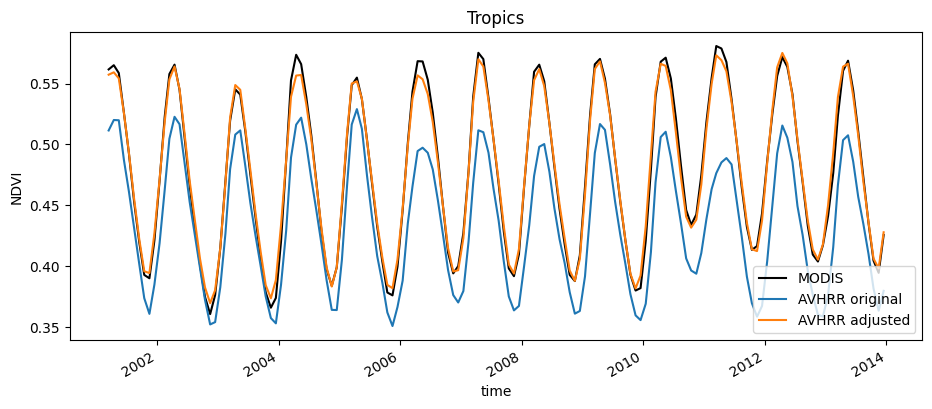

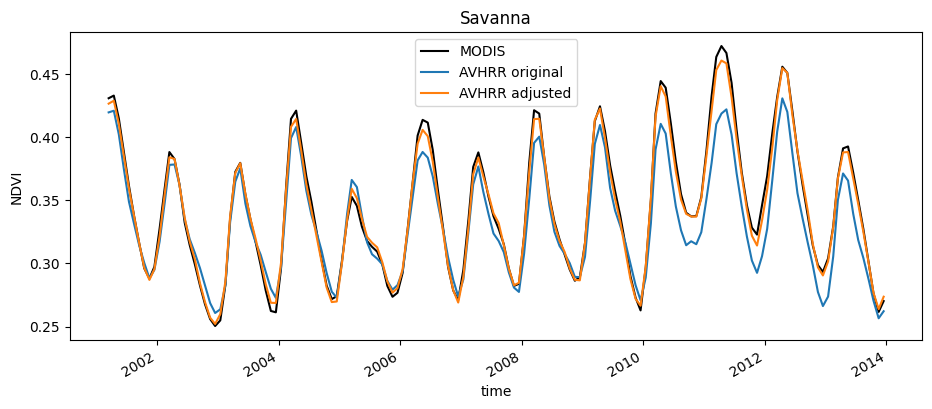

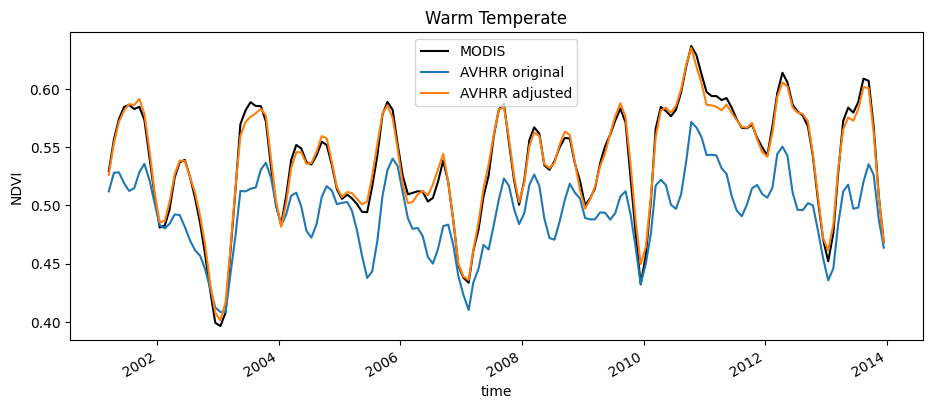

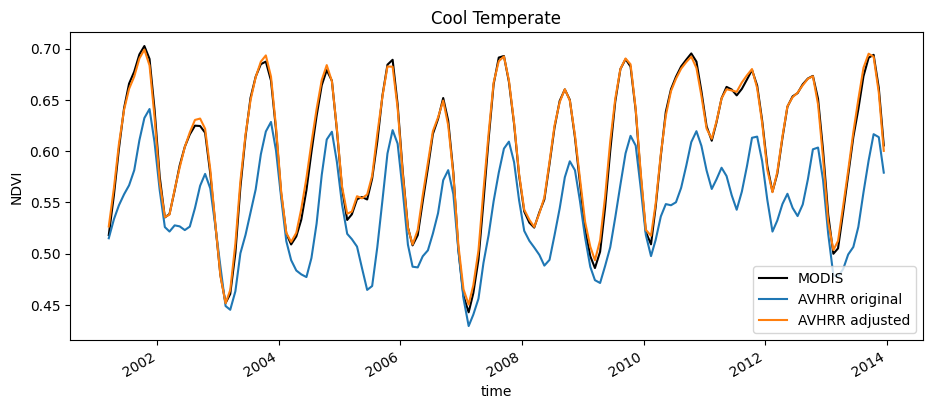

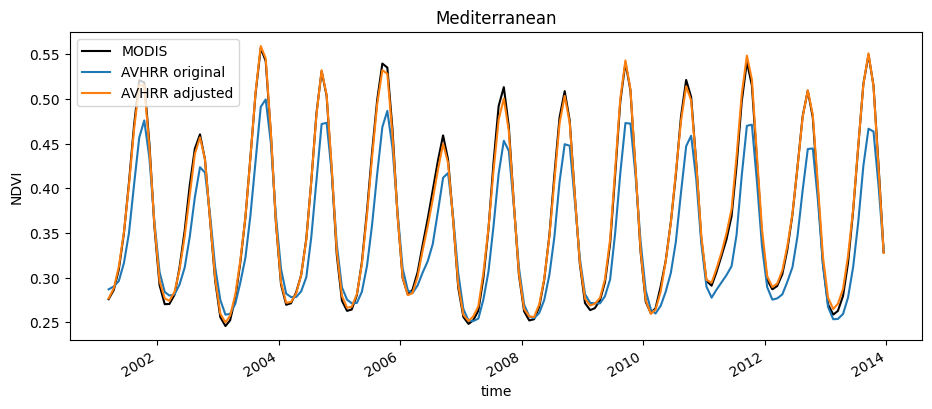

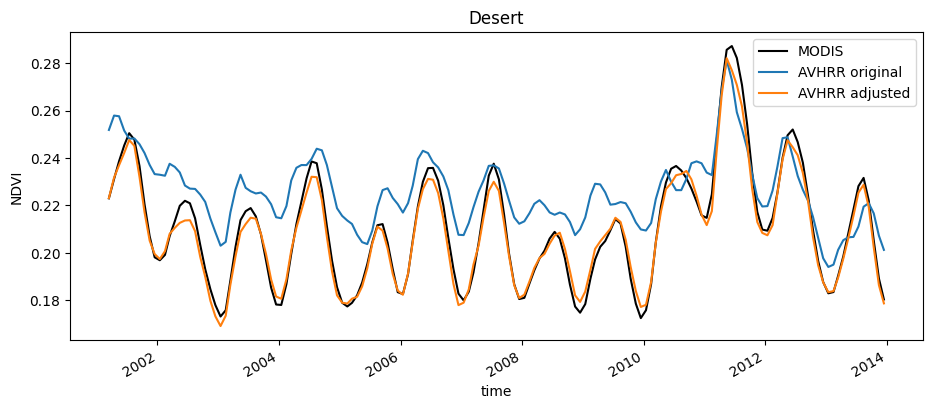

In [11]:
for index, row in gdf.iterrows():
    print(row['region_name'])
        
    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], merge, crs='epsg:3577')
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    modis_region = modis.where(mask)
    avhrr_region = avhrr.where(mask).sel(time=slice('2001', '2013'))
    merge_region = merge.where(mask)
    
    fig, ax = plt.subplots(1,1, figsize=(11,4))
    modis_region.mean(['x','y']).rolling(time=3).mean().plot(ax=ax, label='MODIS', c='black')
    avhrr_region.mean(['x','y']).rolling(time=3).mean().plot(ax=ax, label='AVHRR original')
    merge_region.mean(['x','y']).rolling(time=3).mean().plot(ax=ax, label='AVHRR adjusted')
    ax.legend()
    ax.set_title(row['region_name']);

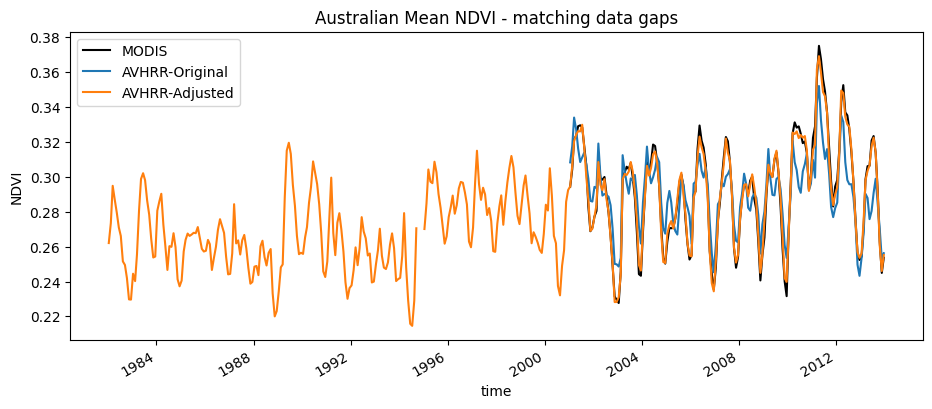

In [38]:
fig,ax = plt.subplots(1,1, figsize=(11,4))
modis.mean(['x','y']).plot(ax=ax, label='MODIS', color='black')
avhrr.sel(time=slice('2001', '2013')).mean(['x','y']).plot(ax=ax, label='AVHRR-Original')
merge.mean(['x','y']).plot(ax=ax, label='AVHRR-Adjusted')
ax.set_title('Australian Mean NDVI - matching data gaps')
ax.set_ylabel('NDVI')
ax.legend();

### Per-pixel error metrics

In [14]:
adjusted_corr = xr.corr(modis,merge,dim='time')
orig_corr = xr.corr(modis, avhrr.sel(time=slice('2001', '2013')), dim='time')

orig_mape = xs.mape(modis, avhrr.sel(time=slice('2001', '2013')), dim='time', skipna=True) *100
adjusted_mape = xs.mape(modis,merge, dim='time', skipna=True) *100

adjusted_rmse = xs.rmse(modis,merge,dim='time', skipna=True)
orig_rmse = xs.rmse(modis,avhrr.sel(time=slice('2001', '2013')), dim='time', skipna=True)

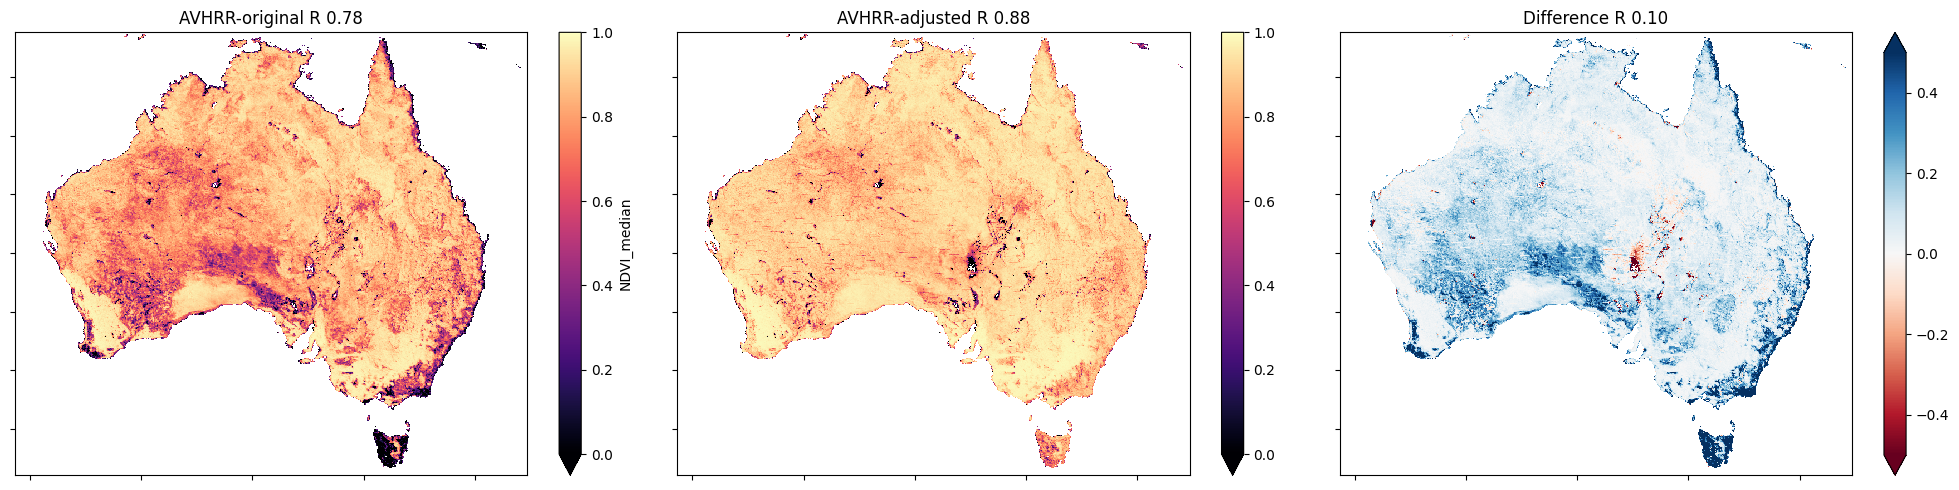

In [15]:
corr_data = [orig_corr, adjusted_corr, adjusted_corr-orig_corr]
products=['AVHRR-original', 'AVHRR-adjusted', 'Difference']

fig,axes = plt.subplots(1,3, figsize=(20,5), sharey=True)

for ax, ds, n in zip(axes.ravel(), corr_data, products):
    if n=='Difference':
        cmap='RdBu'
        vmin=-0.5
        vmax=0.5
    else:
        cmap='magma'
        vmin=0
        vmax=1
    im = ds.plot.imshow(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=True)
    ax.set_title(f'{n} R '"{:.2f}".format(ds.mean().values))
    #ax.set_title(n,  fontsize=15);
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels([])

# fig.subplots_adjust(wspace=0.05)
# fig.colorbar(im, ax=axes.ravel().tolist(), pad=0.01, label='Correlation');
# plt.suptitle('Correlation', fontsize=15)
plt.tight_layout();

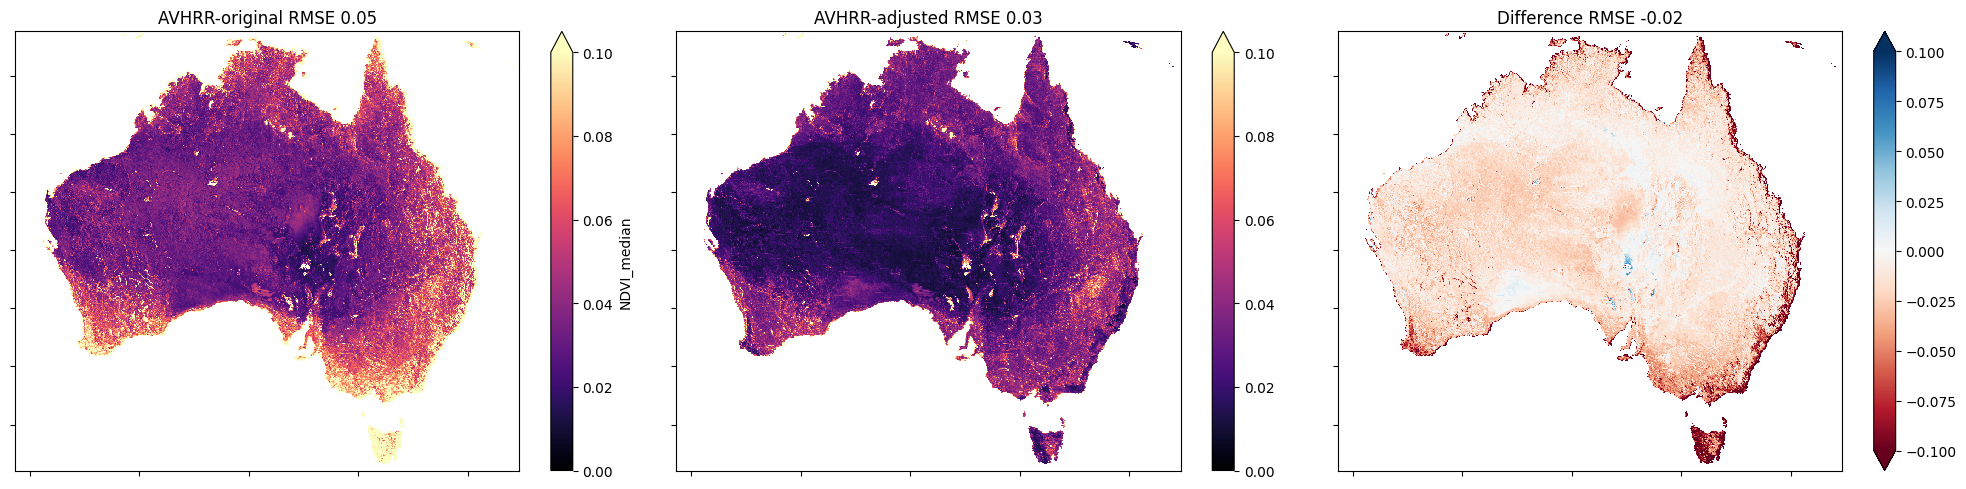

In [26]:
corr_data = [orig_rmse, adjusted_rmse, adjusted_rmse-orig_rmse]
products=['AVHRR-original', 'AVHRR-adjusted', 'Difference']

fig,axes = plt.subplots(1,3, figsize=(20,5), sharey=True)

for ax, ds, n in zip(axes.ravel(), corr_data, products):
    if n=='Difference':
        cmap='RdBu'
        vmin=-0.1
        vmax=0.1
    else:
        cmap='magma'
        vmin=0.0
        vmax=0.1
    im = ds.plot.imshow(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=True)
    ax.set_title(f'{n} RMSE '"{:.2f}".format(ds.mean().values))
    #ax.set_title(n,  fontsize=15);
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels([])

# fig.subplots_adjust(wspace=0.05)
# fig.colorbar(im, ax=axes.ravel().tolist(), pad=0.01, label='Correlation');
# plt.suptitle('Correlation', fontsize=15)
plt.tight_layout();

## Merge the calibrated AVHRR with MODIS

In the AVHRR record, the last 3 months of 1994 are all NaNs, which in the R script means they were discarded from the time-series. This means the time-series in `<var>_AVHRR_MODIS_1982_2013.nc` has missing time-steps.  Below, this is recitified by simply adding 3 empty time-slices. 

> This is only relevant for the GAM model

In [ ]:
# if var=='ndvi':
#     gbox = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/WCF_5km_monthly_1990_2022.nc').odc.geobox

# #grab some time-slices from another dataset
# missing_time_steps = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/WCF_5km_monthly_1990_2022.nc').sel(time=slice('1994-10', '1994-12')).time

### Open the calibrated AVHRR

extract timeseries 1982-2000, resample to epsg:4326 (only if NDVI)

In [ ]:
# ds = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/'+var.upper()+'_harmonization/Harmonized_'+var.upper()+'_AVHRR_MODIS_1982_2013.nc'),
#                    crs=crs)

# ds_pred = ds[var+'_mcd_pred']
# ds_pred = ds_pred.rename(var.upper()).sel(time=slice('1982', '2000'))
# ds_pred.attrs['nodata'] = np.nan

# if var=='ndvi':
#     ds_pred = ds_pred.odc.reproject(gbox, resampling='bilinear')
# ds_pred = round_coords(ds_pred)

### Creating three empty slices of data

and merge back with calibrated avhrr

In [ ]:
# extras = ds_pred.isel(time=range(0,3)) # just grab 3 random slices
# extras = xr.where(extras>100000,np.nan, np.nan) #make values all NaNs
# extras['time'] = missing_time_steps #change time-stamp to missing values
# extras = round_coords(extras)

In [ ]:
# ds_pred = xr.concat([ds_pred, extras], dim='time').sortby('time')

### Merge calibrated AVHRR with MODIS

reopen datasets and merge

In [50]:
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

trees_lgbm = xr.open_dataset(base+'NDVI_harmonization/NDVI_trees_LGBM_harmonize_test_5km_monthly_1982_2013.nc')['NDVI']
nontrees_lgbm = xr.open_dataset(base+'NDVI_harmonization/NDVI_nontrees_LGBM_harmonize_test_5km_monthly_1982_2013.nc')['NDVI']

modis = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/NDVI_harmonization/MODIS_NDVI_5km_monthly_2001_2022.nc')['NDVI_median']
modis = assign_crs(modis, crs ='epsg:3577')

merge = xr.where(np.isnan(trees_lgbm), nontrees_lgbm, trees_lgbm)
merge = assign_crs(merge, crs ='epsg:3577')

Reproject datasets to lat/lon

In [53]:
#get a geobox
gbox = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/WCF_5km_monthly_1982_2022.nc').odc.geobox

modis.attrs['nodata'] = np.nan
merge.attrs['nodata'] = np.nan

if var=='ndvi':
    modis = modis.odc.reproject(gbox, resampling='bilinear')
    modis = round_coords(modis)
    merge = merge.odc.reproject(gbox, resampling='bilinear')
    merge = round_coords(merge)

modis = modis.rename(var.upper())


In [57]:
merged = xr.concat([merge.sel(time=slice('1982','2000')), modis], dim='time')
merged = merged.rename(var.upper())

In [77]:
merged.astype(np.float32).to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/'+var.upper()+'_harmonization/'+var.upper()+'_LGBM_5km_monthly_1982_2022_wGaps.nc')

## Gap-filling

Try with climatologies and linear interp

In [ ]:
import os
import xarray as xr
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs

In [ ]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

In [ ]:
var='lst'
crs='epsg:4326'

file='/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/'+var.upper()+'_5km_monthly_1982_2022_wGaps.nc'
chunks=dict(latitude=1000, longitude=1000, time=-1)

ds = assign_crs(xr.open_dataset(file, chunks=chunks), crs=crs)

### Count fraction of missing data

In [ ]:
mask = np.isnan(ds[var.upper()].mean('time').compute())
mask = (~mask)

total_valid_pixels = mask.sum().values
nans = np.isnan(ds[var.upper()].compute())
num_of_nans = nans.where(mask).sum(['latitude', 'longitude'])
num_of_nans_normalised = num_of_nans / total_valid_pixels

### Plot fraction missing against rainfall

To see if missing data coincides with increased cloud coverage

In [ ]:
rain = xr.open_dataset('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/rain_5km_monthly_1981_2022.nc').rain

In [ ]:
# #compute climatology
# rain_clim = rain.sel(time=slice('1982', '2012')).groupby("time.month").mean("time")#.compute()
# rain_anom = rain.groupby("time.month") - rain_clim

In [ ]:
rain = rain.sel(time=slice('1982', '2000')).mean(['latitude', 'longitude'])
df = rain.to_dataframe('Rainfall')

#Add fractions missing to dataframe for easy plotting
df['Fraction Missing'] = num_of_nans_normalised.sel(time=slice('1982', '2000')).drop('spatial_ref').to_dataframe()

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(13,4))
ax2 = ax.twinx()

# sb.barplot(data=df, x=df.index, y='Rainfall Anomaly', ax=ax2, color='skyblue')
ax2.bar(df.index, height=df['Rainfall'], width=20, color='skyblue')
sb.lineplot(data=df, x=df.index, y='Fraction Missing', ax=ax, c='black')
ax2.set_zorder(ax.get_zorder()-1)
ax2.set_ylabel('Mean Rainfall (mm)')
ax.set_frame_on(False)

### Per pixel fractions of missing data

In [ ]:
avhrr_nans = (~nans).sel(time=slice('1982', '2000'))

In [ ]:
(avhrr_nans.sum('time')/len(avhrr_nans.time)).where(mask).plot(add_labels=False, vmin=0, vmax=1, cmap='inferno', size=6)
plt.title('AVHRR Available Fraction of Data, monthly: 1982-2000');

## Test some interpolation methods

#### Select some areas

In [ ]:
test_area_1 = ds[var.upper()].isel(latitude=range(115,120), longitude=range(355,360)) #Northern Territory tropical savannah
test_area_2 = ds[var.upper()].isel(latitude=range(455,460), longitude=range(100,105)) # SW WA cropping
test_area_3 = ds[var.upper()].isel(latitude=range(545,550), longitude=range(745,750)) # SE Aus forest

#summarise
test_area_1 = test_area_1.sel(time=slice('1982', '2000')).mean(['latitude', 'longitude'])
test_area_2 = test_area_2.sel(time=slice('1982', '2000')).mean(['latitude', 'longitude'])
test_area_3 = test_area_3.sel(time=slice('1982', '2000')).mean(['latitude', 'longitude'])

### Conduct various interpolations

In [ ]:
## ---------Interpolate area 1------------------------------------------------------------

linear_area_1 = test_area_1.interpolate_na(method='linear', dim='time', limit=3)
slinear_area_1 = test_area_1.interpolate_na(method='slinear', dim='time', limit=3)
cubic_area_1 = test_area_1.interpolate_na(method='cubic', dim='time', limit=3)

#fill with climatology
test_area_1_clim = ds[var.upper()].isel(latitude=range(115,120),
                                longitude=range(355,360)).groupby("time.month").mean("time")
test_area_1_clim = test_area_1.groupby("time.month").mean("time")#.compute()
clim_area_1 = test_area_1.groupby("time.month").fillna(test_area_1_clim)

#combined fill
combine_area_1 = linear_area_1.groupby("time.month").fillna(clim_area_1).compute()

## ---------Interpolate area 2-------------------------------------------------------------
linear_area_2 = test_area_2.interpolate_na(method='linear', dim='time', limit=3)
slinear_area_2 = test_area_2.interpolate_na(method='slinear', dim='time', limit=3)
cubic_area_2 = test_area_2.interpolate_na(method='cubic', dim='time', limit=3)

#fill with climatology
test_area_1_clim = ds[var.upper()].isel(latitude=range(115,120),
                                longitude=range(355,360)).groupby("time.month").mean("time")
test_area_2_clim = test_area_2.groupby("time.month").mean("time")#.compute()
clim_area_2 = test_area_2.groupby("time.month").fillna(test_area_2_clim)

#combined fill
combine_area_2 = linear_area_2.groupby("time.month").fillna(clim_area_2).compute()

## ---------Interpolate area 3--------------------------------------------------------------

linear_area_3 = test_area_3.interpolate_na(method='linear', dim='time', limit=3)
slinear_area_3 = test_area_3.interpolate_na(method='slinear', dim='time', limit=3)
cubic_area_3 = test_area_3.interpolate_na(method='cubic', dim='time', limit=3)

#fill with climatology
test_area_1_clim = ds[var.upper()].isel(latitude=range(115,120),
                                longitude=range(355,360)).groupby("time.month").mean("time")
test_area_3_clim = test_area_3.groupby("time.month").mean("time")
clim_area_3 = test_area_3.groupby("time.month").fillna(test_area_3_clim)

#combined fill
combine_area_3 = linear_area_3.groupby("time.month").fillna(clim_area_3).compute()

### Plot the interpolation results

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(13,4), sharey=True)

combine_area_1.plot(ax=ax, label='linear+climatology', linestyle='--', c='green')
linear_area_1.plot(ax=ax, label='linear', linestyle='dashdot', c='red')
test_area_1.plot(ax=ax, label='original', c='black')

ax.set_title('Northern Territory test area for interpolation')
ax.legend();

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(13,4), sharey=True)

combine_area_2.plot(ax=ax, label='linear+climatology', linestyle='--', c='green')
linear_area_2.plot(ax=ax, label='linear', linestyle='dashdot', c='red')
test_area_2.plot(ax=ax, label='original', c='black')
ax.set_title('SW WA test area for interpolation')
ax.legend();

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(13,4), sharey=True)

combine_area_3.plot(ax=ax, label='linear+climatology', linestyle='--', c='green')
linear_area_3.plot(ax=ax, label='linear', linestyle='dashdot', c='red')

test_area_3.plot(ax=ax, label='original', c='black')
ax.set_title('SE Aus forest test area for interpolation')
ax.legend();

### Fill dataset using the combined interpolation approach

First linear interpolate maximum 3 steps. Then fill remaining gaps with climatology

In [ ]:
#inter[olate nans with linear method
ds_linear = ds.interpolate_na(method='linear', dim='time', limit=3)

#compute climatology
clim = ds.groupby("time.month").mean("time")

#fill remaining gaps with climatology
ds_combine = ds_linear.groupby("time.month").fillna(clim).compute()

### Compare

In [ ]:
# fig,ax = plt.subplots(1,1, figsize=(13,5), sharey=True)
# ds.NDVI.sel(time=slice('1982','2000')).mean(['latitude', 'longitude']).plot(ax=ax, label='No-fill')
# ds_linear.NDVI.sel(time=slice('1982','2000')).mean(['latitude', 'longitude']).plot(ax=ax, label='linear')
# ds_combine.NDVI.sel(time=slice('1982','2000')).mean(['latitude', 'longitude']).plot(ax=ax, label='linear+climatology')
# ax.legend()
# plt.title('Australia wide')

## Consider using CLIMFILL for gapfilling:

https://github.com/climachine/climfill/blob/master/example_workflow.py

## Export results

In [ ]:
ds_combine.drop('month').to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/5km/'+var.upper()+'_5km_monthly_1982_2022.nc')